In [1]:
import time
import os
import cv2
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from PIL import Image
import shutil

In [2]:
num_workers = 2 #change this parameter based on your system configuration
batch_size = 32 #change this parameter based on your system configuration
seed = 24
random.seed(seed)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['Covid', 'Normal', 'Viral Pneumonia']
num_classes = len(categories)
splits = ['train', 'val', 'test']

In [3]:
DATA_PATH = 'CovidData'

In [4]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df
df_dataset = show_dataset()

                code train val test  total
Covid              0   200  25   25    250
Normal             1   200  25   25    250
Viral Pneumonia    2   200  25   25    250
TOTAL                  600  75   75    750


In [5]:
def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
                                    [transforms.Resize(299),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform_dict['model'])
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

In [6]:
len(dataset)

750

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cpu


Class: Covid


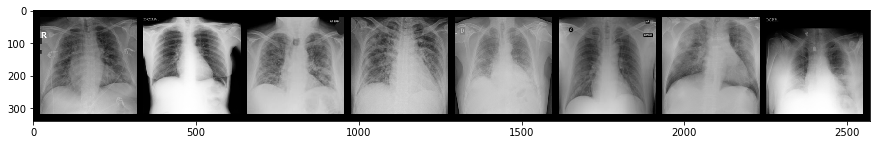

Class: Normal


<Figure size 432x288 with 0 Axes>

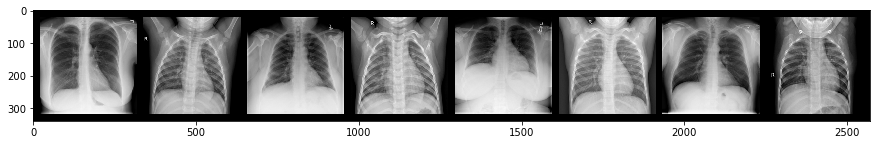

Class: Viral Pneumonia


<Figure size 432x288 with 0 Axes>

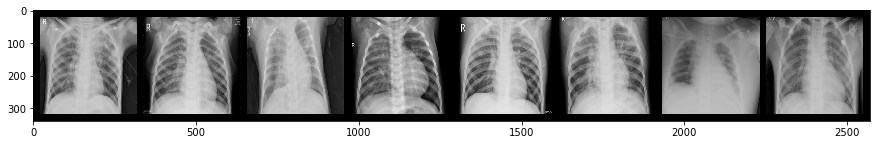

<Figure size 432x288 with 0 Axes>

In [8]:
def show_batch_images(dataset):
    n_images, scale = 8, 3
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle = True)
    images, labels = next(iter(data_loader))
    for i in range(len(categories)):
        print(f'Class: {categories[i]}')
        images_category = images[labels==i][:n_images]
        grid = torchvision.utils.make_grid(images_category, padding=20)
        npgrid = grid.cpu().numpy()
        plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
        plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        plt.show()
        plt.savefig('x-ray[i].pdf')  

show_batch_images(train_data)

In [9]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

In [10]:
def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

In [11]:
def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

In [12]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [13]:
def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    return predictions, actuals

In [14]:
def train_val_model(model):
    t_start = time.time()
    global best_val_model
    global best_val_loss
    best_val_loss = 1
    global best_val_epoch
    best_val_epoch = 0
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size]
        if epoch >= best_val_epoch + 15:
            break
        if use_scheduler: scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
    #print(f"Best model has val loss={best_val_loss:.5f} for {best_val_epoch} epochs")
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

In [15]:
def train_val_model_kfold(model, train_loader_kfold):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs")
    train_size = len(train_loader_kfold)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        #model.train()
        train_loss = 0.0
        for i, (data, target) in enumerate(train_loader_kfold):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size]
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

In [16]:
def accuracy_model(model, loader):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

In [17]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    if model_name == "vgg16":
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "vgg19":
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    else:
        print("Invalid model name, exiting...")
        exit()
    
    model_ft.to(device)
    return model_ft

In [18]:
vgg16_model = initialize_model("vgg16", num_classes, use_pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\LENOVO/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [19]:
np.random.seed(seed)
torch.manual_seed(seed)
model_name = 'VGG16'
n_epochs = 20
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16_model.parameters(), lr=learning_rate)
use_scheduler = False   # Set True if using scheduler
pretrained_model, df_vgg16_epochs = train_val_model(vgg16_model)

Training model VGG16 with 600 samples and max of 20 epochs, and validating with 75 samples

Epoch 1:	 train loss=0.88241 	 val loss=0.74912 	 time=487.62s
Epoch 2:	 train loss=0.65016 	 val loss=0.56186 	 time=485.39s
Epoch 3:	 train loss=0.56364 	 val loss=0.42788 	 time=484.28s
Epoch 4:	 train loss=0.50687 	 val loss=0.36241 	 time=477.77s
Epoch 5:	 train loss=0.47177 	 val loss=0.40725 	 time=473.74s
Epoch 6:	 train loss=0.46783 	 val loss=0.32341 	 time=475.04s
Epoch 7:	 train loss=0.41355 	 val loss=0.33215 	 time=378.13s
Epoch 8:	 train loss=0.40706 	 val loss=0.30466 	 time=334.33s
Epoch 9:	 train loss=0.39818 	 val loss=0.29005 	 time=330.98s
Epoch 10:	 train loss=0.38062 	 val loss=0.29514 	 time=334.39s
Epoch 11:	 train loss=0.37905 	 val loss=0.26679 	 time=332.92s
Epoch 12:	 train loss=0.35186 	 val loss=0.25544 	 time=335.58s
Epoch 13:	 train loss=0.33733 	 val loss=0.25716 	 time=344.60s
Epoch 14:	 train loss=0.38847 	 val loss=0.26948 	 time=338.04s
Epoch 15:	 train loss

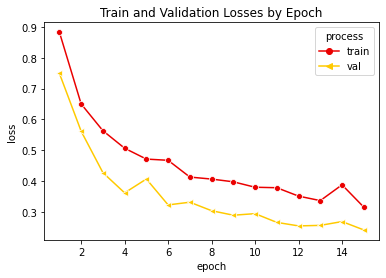

In [20]:
plot_train_val_losses(df_vgg16_epochs)

In [21]:
test_vgg16_results, conf_vgg16_matrix_test = accuracy_model(pretrained_model, test_loader)

Testing the model VGG16 with 75 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.893333   0.897205  0.893333  0.892229


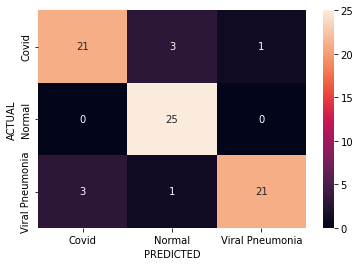

In [22]:
_ = sns.heatmap(conf_vgg16_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

In [23]:
from sklearn.model_selection import KFold
def validate_model_kfold(model, model_name, k_folds):
    #model.eval()
    print(f"Validating the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {k_folds}-folds \n")
    df = pd.DataFrame(columns = metrics)
    kfold = KFold(n_splits=k_folds, shuffle=True)
    print(len(dataset))
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        train_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_subsampler)
        test_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_subsampler)
        #model.apply(reset_weights)
        model, df_vgg_epochs = train_val_model_kfold(model, train_kfold_loader)
        predictions, actuals = calc_pred_actuals(model, test_kfold_loader)
        conf_matrix = create_confusion_matrix(predictions, actuals)
        df_aux = calc_metrics(predictions, actuals, 'FOLD '+str(fold+1))
        df = df.append(df_aux)      
    df.loc['Average'] = df.mean(axis=0)
    print(df.astype(float))
    return df.astype(float), conf_matrix

In [24]:
validation_our_model_results, conf_matrix_our_model_val = validate_model_kfold(vgg16_model, model_name = 'VGG16', k_folds = 5)

Validating the model VGG16 with 600 samples and 5-folds 

750
Training model VGG16 with 600 samples and max of 20 epochs
Epoch 1:	 train loss=0.28482 	 time=293.48s
Epoch 2:	 train loss=0.27862 	 time=283.77s
Epoch 3:	 train loss=0.26703 	 time=282.77s
Epoch 4:	 train loss=0.25864 	 time=281.95s
Epoch 5:	 train loss=0.25677 	 time=278.18s
Epoch 6:	 train loss=0.24372 	 time=289.03s
Epoch 7:	 train loss=0.23734 	 time=341.93s
Epoch 8:	 train loss=0.23110 	 time=394.62s
Epoch 9:	 train loss=0.22731 	 time=387.63s
Epoch 10:	 train loss=0.22240 	 time=387.57s
Epoch 11:	 train loss=0.21729 	 time=394.68s
Epoch 12:	 train loss=0.21271 	 time=392.41s
Epoch 13:	 train loss=0.20833 	 time=394.27s
Epoch 14:	 train loss=0.20368 	 time=397.13s
Epoch 15:	 train loss=0.19944 	 time=398.55s
Epoch 16:	 train loss=0.19675 	 time=410.97s
Epoch 17:	 train loss=0.19330 	 time=409.95s
Epoch 18:	 train loss=0.19066 	 time=292.85s
Epoch 19:	 train loss=0.18500 	 time=267.77s
Epoch 20:	 train loss=0.18441 	 t